## ViEWS 3: Fatalities descriptives, time series and top 10, single country history
#### Notebook to describe the dependent variables for the fatalities project, cm level

## 6.  Sum up ged_best_ xx all months 1990-2020 for all countries (M)
#### sum up ged_best_xx across all months 1990--2020 for all countries, density plots for these sums

Interpretation of the prompt is: for each country derive a sum of all fatalities for all month_id. Then create a fatalities density plot 

Please note that the max values seem to be quite high. Suspected cause of elevation of the values is the way they are imputed and pushed forward. Solution would either be to limit the size of the dataset during out query to year 2020 only at most to avoid counting values into the future that have never been zeroed or change imputation style. As of right now, I believe that the sum values are artificially elevated due to the way final fatalities count is pushed into the future and not currently set to 0 as it likely should be.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as mplot
from matplotlib.legend_handler import HandlerTuple
#import seaborn as sns
#import plotly.express as px
from viewser import Queryset, Column
import pycountry

from ingester3.scratch import cache_manager
cache_manager()
from ingester3.Country import Country
from ingester3.extensions import *
from datetime import date
from ingester3.ViewsMonth import ViewsMonth

Clearing Cache


#### Short formulas that will come in handy in the future ingestion, created for some portions of the current graph making (may and may not come in handy)

In [2]:
#use for ingestion
def name2iso(i):
    str(i)
    try:
        output = pycountry.countries.get(name=i).alpha_3
    except AttributeError: 
        try:
            output = 'no match, did you mean'+' ' + str(pycountry.countries.search_fuzzy(i)[0])
        except LookupError:
            output= 'check_spelling'
    return output

#use for quick checks in the below, note ingester does a better job of maching country id based on year for countries
#that change their ids over time, e.g.Ethiopia
def name2id(i):
    str(i)
    try:
        output = Country.from_iso(pycountry.countries.get(name=i).alpha_3).id
    except AttributeError: 
        try:
            output = 'no match, did you mean'+' ' + str(pycountry.countries.search_fuzzy(i)[0])
        except LookupError:
            output= 'check_spelling'
    return output

def vid2date(i):
    year=str(ViewsMonth(i).year)
    month=str(ViewsMonth(i).month)
    return year+'/'+month

#### shortened queryset, we do not need time lags in the part B section

In [3]:
queryset = (Queryset("m_f_fat_description", "country_month")
              #CONFLICT TYPES NOT LOGGED and NOT time lagged 
            .with_column(Column("ged_best_sb", from_table = "ged2_cm", from_column = "ged_sb_best_sum_nokgi")
                         .transform.missing.fill()
                        )
            .with_column(Column("ged_best_ns", from_table = "ged2_cm", from_column = "ged_ns_best_sum_nokgi")
                         .transform.missing.fill()
                        )
            .with_column(Column("ged_best_os", from_table = "ged2_cm", from_column = "ged_os_best_sum_nokgi")
                         .transform.missing.fill()
                        )
            
          #logged
            .with_column(Column("ln_ged_sb", from_table = "ged2_cm", from_column = "ged_sb_best_sum_nokgi")
                         .transform.ops.ln()
                         .transform.missing.fill()
                        )
            
            .with_column(Column("ln_ged_ns", from_table = "ged2_cm", from_column = "ged_ns_best_sum_nokgi")
                         .transform.ops.ln()
                         .transform.missing.fill()
                        )
            .with_column(Column("ln_ged_os", from_table = "ged2_cm", from_column = "ged_os_best_sum_nokgi")
                         .transform.ops.ln()
                         .transform.missing.fill()
                        )
                         
            .with_theme("fatalities")
                         
            .describe("""Fatalities conflict history, cm level
            Fatalities description 
                
            """)
            
           )

fat_data = queryset.publish().fetch()
fat_data

 .    

ged_best_sb  ged_best_ns  ged_best_os  ln_ged_sb  \
month_id country_id                                                     
1        1                   0.0          0.0          0.0   0.000000   
         2                   0.0          0.0          0.0   0.000000   
         3                   0.0          0.0          0.0   0.000000   
         4                   0.0          0.0          0.0   0.000000   
         5                   0.0          0.0          0.0   0.000000   
...                          ...          ...          ...        ...   
852      242                 0.0          0.0          0.0   0.000000   
         243                 3.0          0.0          0.0   1.386294   
         244                 0.0          0.0          0.0   0.000000   
         245                 0.0        213.0         68.0   0.000000   
         246                 0.0         79.0         35.0   0.000000   

                     ln_ged_ns  ln_ged_os  
month_id country_id                        
1        1            0.000000   0.000000  
         2            0.000000   0.000000  
         3            0.000000   0.000000  
         4            0.000000   0.000000  
         5            0.000000   0.000000  
...                        ...        ...  
852      242          0.000000   0.000000  
         243          0.000000   0.000000  
         244          0.000000   0.000000  
         245          5.365976   4.234107  
         246          4.382027   3.583519  

[158230 rows x 6 columns]

In [4]:
#test the system and locate the months and dates
print(Country(220))
#test the range
print(ViewsMonth(121), ViewsMonth(492))
print(ViewsMonth(421), ViewsMonth(456))
print(ViewsMonth(457))

Country(id=220) #=> name:Syria, gwcode:652, iso:SYR, capital:Damascus, in_africa:False, in_me:True
ViewsMonth(id=121) #=> year:1990, month:1 ViewsMonth(id=492) #=> year:2020, month:12
ViewsMonth(id=421) #=> year:2015, month:1 ViewsMonth(id=456) #=> year:2017, month:12
ViewsMonth(id=457) #=> year:2018, month:1


In [19]:
#limit data to 121 (Jan 1990) to 492(December 2020)
#also make ranges for 2015-2017 and 2018-2020

#note that range notation in python runs counter to others as it it [a, b) and not the usual [a,b]
good_range = list(range(121,493))
range15_17 = list(range(421,457))
range18_20 = list(range(457, 493))

#limit data based on range
lim_fat_data = fat_data.loc[good_range,]
lim_fat_data15_17 = fat_data.loc[range15_17, ]
lim_fat_data18_20 = fat_data.loc[range18_20, ]
display(fat_data)
display(lim_fat_data)
display(lim_fat_data.head(500))

#### quick check of data
display(lim_fat_data.info())
display(lim_fat_data.agg([min, max]))
display(lim_fat_data.isnull().any())

ged_best_sb  ged_best_ns  ged_best_os  ln_ged_sb  \
month_id country_id                                                     
1        1                   0.0          0.0          0.0   0.000000   
         2                   0.0          0.0          0.0   0.000000   
         3                   0.0          0.0          0.0   0.000000   
         4                   0.0          0.0          0.0   0.000000   
         5                   0.0          0.0          0.0   0.000000   
...                          ...          ...          ...        ...   
852      242                 0.0          0.0          0.0   0.000000   
         243                 0.0          0.0          0.0   0.000000   
         244                 0.0          0.0          0.0   0.000000   
         245                 0.0          0.0          8.0   0.000000   
         246                 1.0         54.0         20.0   0.693147   

                     ln_ged_ns  ln_ged_os  
month_id country_id                        
1        1            0.000000   0.000000  
         2            0.000000   0.000000  
         3            0.000000   0.000000  
         4            0.000000   0.000000  
         5            0.000000   0.000000  
...                        ...        ...  
852      242          0.000000   0.000000  
         243          0.000000   0.000000  
         244          0.000000   0.000000  
         245          0.000000   2.197225  
         246          4.007333   3.044522  

[158230 rows x 6 columns]

ged_best_sb  ged_best_ns  ged_best_os  ln_ged_sb  \
month_id country_id                                                     
121      1                   0.0          0.0          0.0        0.0   
         2                   0.0          0.0          0.0        0.0   
         3                   0.0          0.0          0.0        0.0   
         4                   0.0          0.0         12.0        0.0   
         5                   0.0          0.0          0.0        0.0   
...                          ...          ...          ...        ...   
492      242                 0.0          0.0          0.0        0.0   
         243                 0.0          0.0          0.0        0.0   
         244                 0.0          0.0          0.0        0.0   
         245                 0.0         25.0          7.0        0.0   
         246                 0.0          0.0          2.0        0.0   

                     ln_ged_ns  ln_ged_os  
month_id country_id                        
121      1            0.000000   0.000000  
         2            0.000000   0.000000  
         3            0.000000   0.000000  
         4            0.000000   2.564949  
         5            0.000000   0.000000  
...                        ...        ...  
492      242          0.000000   0.000000  
         243          0.000000   0.000000  
         244          0.000000   0.000000  
         245          3.258097   2.079442  
         246          0.000000   1.098612  

[69732 rows x 6 columns]

ged_best_sb  ged_best_ns  ged_best_os  ln_ged_sb  \
month_id country_id                                                     
121      1                   0.0          0.0          0.0   0.000000   
         2                   0.0          0.0          0.0   0.000000   
         3                   0.0          0.0          0.0   0.000000   
         4                   0.0          0.0         12.0   0.000000   
         5                   0.0          0.0          0.0   0.000000   
...                          ...          ...          ...        ...   
123      223                49.0          9.0         73.0   3.912023   
         234                 0.0          0.0          0.0   0.000000   
         235               300.0          0.0          1.0   5.707110   
         236                 0.0          0.0          0.0   0.000000   
         237                 0.0          0.0          0.0   0.000000   

                     ln_ged_ns  ln_ged_os  
month_id country_id                        
121      1            0.000000   0.000000  
         2            0.000000   0.000000  
         3            0.000000   0.000000  
         4            0.000000   2.564949  
         5            0.000000   0.000000  
...                        ...        ...  
123      223          2.302585   4.304065  
         234          0.000000   0.000000  
         235          0.000000   0.693147  
         236          0.000000   0.000000  
         237          0.000000   0.000000  

[500 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 69732 entries, (121, 1) to (492, 246)
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ged_best_sb  69732 non-null  float64
 1   ged_best_ns  69732 non-null  float64
 2   ged_best_os  69732 non-null  float64
 3   ln_ged_sb    69732 non-null  float64
 4   ln_ged_ns    69732 non-null  float64
 5   ln_ged_os    69732 non-null  float64
dtypes: float64(6)
memory usage: 3.5 MB


None

,ged_best_sb,ged_best_ns,ged_best_os,ln_ged_sb,ln_ged_ns,ln_ged_os
min,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,48183.0,5664.0,435945.0,10.782782,8.642062,12.985274


ged_best_sb    False
ged_best_ns    False
ged_best_os    False
ln_ged_sb      False
ln_ged_ns      False
ln_ged_os      False
dtype: bool

In [20]:
#the below will show that the lim data is a more useful dataset to use as there is something wrong with imputation
#aggregation by country_id across all time vs. limited time range
fat_sum = pd.DataFrame(fat_data.groupby('country_id').agg({"ged_best_sb": "sum", 
                                                           "ged_best_ns":"sum", 
                                                           "ged_best_os":"sum"}))

lim_fat_sum =  pd.DataFrame(lim_fat_data.groupby('country_id').agg({"ged_best_sb": "sum", 
                                                           "ged_best_ns":"sum", 
                                                           "ged_best_os":"sum"}))
display(fat_sum)
display(lim_fat_sum)

#please note the huge difference limiting the data to available data makes
#need to fix the imputation.
#in the meantime, it is obvious that lim_fat_data is more accurate
display(fat_sum.agg([min, max]))
display(lim_fat_sum.agg([min,max]))

,ged_best_sb,ged_best_ns,ged_best_os
country_id,,,
1,0.0,0.0,29.0
2,0.0,0.0,0.0
3,39.0,0.0,0.0
4,1898.0,171.0,7965.0
5,0.0,0.0,0.0
...,...,...,...
248,0.0,0.0,0.0
250,0.0,0.0,0.0
252,0.0,0.0,0.0


,ged_best_sb,ged_best_ns,ged_best_os
country_id,,,
1,0.0,0.0,29.0
2,0.0,0.0,0.0
3,39.0,0.0,0.0
4,146.0,164.0,586.0
5,0.0,0.0,0.0
...,...,...,...
248,0.0,0.0,0.0
250,0.0,0.0,0.0
252,0.0,0.0,0.0


,ged_best_sb,ged_best_ns,ged_best_os
min,0.0,0.0,0.0
max,379783.0,151384.0,545412.0


,ged_best_sb,ged_best_ns,ged_best_os
min,0.0,0.0,0.0
max,328250.0,58716.0,545412.0


In [ ]:
#now for the kernel density plot with logged Fatalities
#note that sb and os are once again more likely to result in higher fatalities
#this is unusual, but perhaps a result of a single high os country
#additionally note that the xlim was set to 1
#as the fatalities in logged cases have to start at one due to transformation

log_scale_value = np.array([np.log(1), np.log(10), np.log(100), np.log(1000), np.log(10000), 
             np.log(100000), np.log(1000000), np.log(8000000)])
log_scale_naming = ['1', '10', '100', '1000', '10000', '100000','1000000', '8000000']

np.log(lim_fat_sum+1).plot.kde()
mplot.xlim(left=1)
mplot.xticks(log_scale_value, log_scale_naming, rotation=30)
mplot.title('Density plot for all fatalities between 1990-2020 by country, all 3 subtypes', y=1.08)
mplot.xlabel('Fatalities 1990-2020 per country')
mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Kernel_density_plots_grouped/Density_plot_all_fat_1990_2020_by_country.png", 
           bbox_inches='tight')

In [ ]:
#now for kernel density plot for 2015-2017 only, logged fatalities
#note that there seem to be less chances of country having a lot of fatalities in its history
#for this smaller time period, which makes sense as this is only 2 years

lim_fat_sum15_17 =  pd.DataFrame(lim_fat_data15_17.groupby('country_id').agg({"ged_best_sb": "sum", 
                                                           "ged_best_ns":"sum", 
                                                           "ged_best_os":"sum"}))

#now for the kernel density plot with logged Fatalities

log_scale_value = np.array([np.log(1), np.log(10), np.log(100), np.log(1000), np.log(10000), 
             np.log(100000), np.log(1000000), np.log(8000000)])
log_scale_naming = ['1', '10', '100', '1000', '10000', '100000','1000000', '8000000']

np.log(lim_fat_sum15_17+1).plot.kde()
mplot.xlim(left=1)
mplot.xticks(log_scale_value, log_scale_naming, rotation=30)
mplot.title('Density plot for all fatalities between 2015-2017 by country, all 3 subtypes', y=1.08)
mplot.xlabel('Fatalities 2015-2017 per country')

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Kernel_density_plots_grouped/Density_plot_all_fat_2015_2017_by_country.png", bbox_inches='tight')


In [ ]:
#now for kernel density plot for 2018-2020 only, logged fatalities
#note the similarity of the densitities for 2015-2017 and 2018-2020, so countries likely to experience similar fat

lim_fat_sum18_20 =  pd.DataFrame(lim_fat_data18_20.groupby('country_id').agg({"ged_best_sb": "sum", 
                                                           "ged_best_ns":"sum", 
                                                           "ged_best_os":"sum"}))

#now for the kernel density plot with logged Fatalities

log_scale_value = np.array([np.log(1), np.log(10), np.log(100), np.log(1000), np.log(10000), 
             np.log(100000), np.log(1000000), np.log(8000000)])
log_scale_naming = ['1', '10', '100', '1000', '10000', '100000','1000000', '8000000']

np.log(lim_fat_sum18_20+1).plot.kde()
mplot.xlim(left=1)
mplot.xticks(log_scale_value, log_scale_naming, rotation=30)
mplot.title('Density plot for all fatalities between 2018-2020 by country, all 3 subtypes', y=1.08)
mplot.xlabel('Fatalities 20118-2020 per country')
mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Kernel_density_plots_grouped/Density_plot_all_fat_2018_2020_by_country.png", bbox_inches='tight')


#### #If the first interpretations was incorrect

alternate aggregation based on month_id, make sure to keep this code as it is needed for later assignment

The logged month id below shows that although os seems to have higher chances for higher fatalities, it might be that the value is skewed by a significantly high single value within the range. when logged it becomes easier to see that per month across all countries, state based violence has higher chances of fatalities. note that now the expected result that sb violence will result in more fatalities has been achieved. 

In [ ]:
#density of fatalities per months for years 1990-2020 on logged scale

lim_fat_sum_months = pd.DataFrame(lim_fat_data.groupby('month_id').agg({"ged_best_sb": "sum", 
                                                                "ged_best_ns":"sum", "ged_best_os":"sum"}))

log_scale_value = np.array([np.log(1), np.log(10), np.log(100), np.log(1000), np.log(10000), 
             np.log(100000), np.log(600000)])
log_scale_naming = ['1', '10', '100', '1000', '10000', '100000','600000']

#same but on logged scale
np.log(lim_fat_sum_months+1).plot.kde()
mplot.xlim(left=1)
mplot.xticks(log_scale_value, log_scale_naming, rotation=30)
mplot.title('Density plot for fatalities per months in 1990-2020, all 3 subtypes', y=1.08)
mplot.xlabel('Fatalities all countries per month')
mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Kernel_density_plots_grouped/Density_plot_all_fat_1990_2020_by_month.png", bbox_inches='tight')


In [ ]:
#density of fatalities per months for years 2015-2017 on logged scale
lim_fat_sum15_17_months = pd.DataFrame(lim_fat_data15_17.groupby('month_id').agg({"ged_best_sb": "sum", 
                                                                "ged_best_ns":"sum", "ged_best_os":"sum"}))

log_scale_value = np.array([np.log(1), np.log(10), np.log(100), np.log(1000), np.log(10000), 
             np.log(100000), np.log(600000)])
log_scale_naming = ['1', '10', '100', '1000', '10000', '100000','600000']

#same but on logged scale
np.log(lim_fat_sum15_17_months+1).plot.kde()
mplot.xlim(left=1)
mplot.xticks(log_scale_value, log_scale_naming, rotation=30)
mplot.title('Density plot for fatalities per months in 2015-2017, all 3 subtypes', y=1.08)
mplot.xlabel('Fatalities all countries per month')
mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Kernel_density_plots_grouped/Density_plot_all_fat_2015_2017_by_month.png", bbox_inches='tight')


In [ ]:
#density of fatalities per months for years 2018-2020 on logged scale
lim_fat_sum18_20_months = pd.DataFrame(lim_fat_data18_20.groupby('month_id').agg({"ged_best_sb": "sum", 
                                                                "ged_best_ns":"sum", "ged_best_os":"sum"}))

log_scale_value = np.array([np.log(1), np.log(10), np.log(100), np.log(1000), np.log(10000), np.log(50000)])
log_scale_naming = ['1', '10', '100', '1000', '10000', '50000']

#same but on logged scale
np.log(lim_fat_sum18_20_months+1).plot.kde()
mplot.xlim(left=1)
mplot.xticks(log_scale_value, log_scale_naming, rotation=30)
mplot.title('Density plot for fatalities per months in 2018-2020, all 3 subtypes', y=1.08)
mplot.xlabel('Fatalities all countries per month')
mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Kernel_density_plots_grouped/Density_plot_all_fat_2018_2020_by_month.png", bbox_inches='tight')


# Assignment 7/8
#### plots of ln_ged_best_xx over time for the 10 countries with the highest sum of fatalities over time
#### all countries on same timeline, top 10 in different color
#### top 10 vs. all other countries summed up

first identify the countries with the high sum of fatalities, create a new variable to mark the top 10, and then join to the lim_fat_data by country_ID. Please note process will need to be completed for each violence subtype. 

Additionally note that in earlier version of this assignment fatalaties time series was captured as is, which resulted in difficult to read time series. Instead employ a centered moving average procedure to smooth out the overall pattern. centered moving average was chosen for its relative ease of application. 

please note that earlier consideration that one-sided violence has a significant single value outlier seems to be correct as seen below. beyond this single value its top 10 fatality countries seem to be more closely resembling the non-state based values

In [ ]:
#Find the smallest value of the top 10 in each violence category, will neeed to be used for dummy variable below

#please note that earlier consideration that one-sided violence has a significant single value outlier seems 
#to be correct as seen below. 
#beyond this single value its top 10 fatality countries seem to be more closely 
#resembling the non-state based values

#top 10 state
lim_fat_sum.nlargest(10, 'ged_best_sb')
sb_top_min = lim_fat_sum.nlargest(10, 'ged_best_sb')
display(sb_top_min)
display(sb_top_min.ged_best_sb.min())

#top 10 non-state
lim_fat_sum.nlargest(10, 'ged_best_ns')
ns_top_min = lim_fat_sum.nlargest(10, 'ged_best_ns')
display(ns_top_min)
display(ns_top_min.ged_best_ns.min())

#top 10 one sided
lim_fat_sum.nlargest(10, 'ged_best_os')
os_top_min = lim_fat_sum.nlargest(10, 'ged_best_os')
display(os_top_min)
display(os_top_min.ged_best_os.min())

#### Use the stored min value in the top 10 to define a dummy variable in lim_fat_sum dataset. 

In [ ]:
#for sb
lim_fat_sum.loc[lim_fat_sum['ged_best_sb'] >= sb_top_min.ged_best_sb.min(), 'top10_sb'] = 1 
lim_fat_sum.loc[lim_fat_sum['ged_best_sb'] < sb_top_min.ged_best_sb.min(), 'top10_sb'] = 0 
#for ns
lim_fat_sum.loc[lim_fat_sum['ged_best_ns'] >= ns_top_min.ged_best_ns.min(), 'top10_ns'] = 1 
lim_fat_sum.loc[lim_fat_sum['ged_best_ns'] < ns_top_min.ged_best_ns.min(), 'top10_ns'] = 0 
#for os
lim_fat_sum.loc[lim_fat_sum['ged_best_os'] >= os_top_min.ged_best_os.min(), 'top10_os'] = 1 
lim_fat_sum.loc[lim_fat_sum['ged_best_os'] < os_top_min.ged_best_os.min(), 'top10_os'] = 0 

lim_fat_sum

#Quick check of the work (change cell type to run)
quick_test = lim_fat_sum.loc[lim_fat_sum['top10_os'] == 1]
display(quick_test)
display(lim_fat_sum.isnull().any())

#### Now to join the dummy variables to the original fat_data 

In [ ]:
#a quick clean up of the fat_sum data
lim_fat_sum_clean = lim_fat_sum.drop(['ged_best_sb', 'ged_best_ns', 'ged_best_os'], axis=1)
display(lim_fat_sum_clean)
lim_fat_data_dummy = lim_fat_data.join(lim_fat_sum_clean, how='left')
display(lim_fat_data_dummy)

#quick check of the work (change cell type to run)
quick_test = lim_fat_data_dummy.loc[lim_fat_data_dummy['top10_sb'] == 1]
display(quick_test)
lim_fat_data_dummy.isnull().any()

#### now to plot top 10 countries over time. Please note that index by country had to be removed to make plots work. 

In [ ]:
lim_fat_data_dummy.reset_index(inplace=True)
lim_fat_data_dummy.set_index('month_id', inplace = True)
lim_fat_data_dummy
gdata=lim_fat_data_dummy

In [ ]:
#below for making a consistent style
#this part is important for creating a consistent style across the graphs
display([Country(i).name for i in list(gdata.loc[gdata.top10_sb > 0].groupby('country_id').groups.keys())])
display(gdata.loc[gdata.top10_sb > 0].groupby('country_id').groups.keys())

display([Country(i).name for i in list(gdata.loc[gdata.top10_ns > 0].groupby('country_id').groups.keys())])
display(gdata.loc[gdata.top10_ns > 0].groupby('country_id').groups.keys())

display([Country(i).name for i in list(gdata.loc[gdata.top10_os > 0].groupby('country_id').groups.keys())])
display(gdata.loc[gdata.top10_os > 0].groupby('country_id').groups.keys())

saving for reference

country_id_collection = [57, 59, 60, 120, 136, 121, 133,  191, 220, 223,
                         57, 59, 9, 120, 17,  79,  213, 167, , 220, 223,
                        43, 59, 60, 83, 156, 79, 133, 167, , 220, 223]

In [ ]:


country_id_collection = [57, 59, 60, 120, 136, 121, 133,  191, 220, 223,
                         9,  17,  79,  213, 167,
                        43,   83, 156]
country_colors = ['blue', 'red', 'lime', 'orange', 'magenta', 'blue', 'red', 'lime', 'orange', 'magenta',
                   'lime',  'magenta', 'blue', 'red', 'lime', 
                'blue',  'orange', 'magenta'  ] 
country_ls = ['-', '-','-','-','-', '-.', '-.', '-.','-.','-.', 
             '-','-', '-.', '-.', '-.',
             '-', '-','-', ]
country_names = [Country(i).name for i in country_id_collection]


cdictionary=pd.DataFrame({
    'country_id' : country_id_collection,
    'color' : country_colors ,
    'line' : country_ls,
    'name' : country_names
})
cdictionary.set_index('country_id', inplace=True)
cdictionary.loc[191, 'name'] = 'pre-war Ethiopia'
display(cdictionary)

time_line_values=np.array(range(121,493, 53))
time_line_names=[vid2date(i) for i in list(range(121,493, 53))]


In [ ]:

cdictionary

#### Table for state-based over time, top10
rolling average presented only as the primary thing of interest

In [ ]:
#now rolling average 
lim_fat_data_dummy_10_sb=lim_fat_data_dummy[lim_fat_data_dummy.top10_sb > 0]
lim_fat_data_dummy_10_sb_rolling_step1 = lim_fat_data_dummy_10_sb.reset_index()
lim_fat_data_dummy_10_sb_rolling_step2 = lim_fat_data_dummy_10_sb_rolling_step1[['month_id','country_id', 'ged_best_sb']]
lim_fat_data_dummy_10_sb_rolling_step2 = lim_fat_data_dummy_10_sb_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_10_sb_rolling=lim_fat_data_dummy_10_sb_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_10_sb_rolling = lim_fat_data_dummy_10_sb_rolling.reset_index()
lim_fat_data_dummy_10_sb_rolling = lim_fat_data_dummy_10_sb_rolling.set_index('month_id')
lim_fat_data_dummy_10_sb_rolling

mplot.figure(figsize=(80,40))

for i in list(lim_fat_data_dummy_10_sb_rolling.groupby('country_id').groups.keys()):
    cdata= lim_fat_data_dummy_10_sb_rolling.groupby('country_id').get_group(i)
    cdata['ged_best_sb'].plot(linewidth = 7, fontsize=60,
                              color= cdictionary.loc[i]['color'], ls=cdictionary.loc[i]['line'], 
                              label=cdictionary.loc[i]['name'])

mplot.xlim((109, 492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)  

mplot.legend(title='Country', title_fontsize=50, loc=6, prop={'size': 50}, bbox_to_anchor=(1, 0.5))
    
    
# Add titles
mplot.title("Top 10 fatality countries 1990-2020 centered moving average, state-based", loc='left', 
            fontsize=80, fontweight=0, color='black',y =1.05)
mplot.xlabel("Time", fontsize=70)
mplot.ylabel("Fatalities, centered moving average", fontsize=70)
 

In [ ]:
#data prep for all country time series
lim_fat_data_dummy_10_sb=lim_fat_data_dummy[lim_fat_data_dummy.top10_sb > 0]
lim_fat_data_dummy_low_sb=lim_fat_data_dummy[lim_fat_data_dummy.top10_sb == 0]

lim_fat_data_dummy_10_sb_rolling_step1 = lim_fat_data_dummy_10_sb.reset_index()
lim_fat_data_dummy_10_sb_rolling_step2 = lim_fat_data_dummy_10_sb_rolling_step1[['month_id','country_id', 'ged_best_sb']]
lim_fat_data_dummy_10_sb_rolling_step2 = lim_fat_data_dummy_10_sb_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_10_sb_rolling=lim_fat_data_dummy_10_sb_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_10_sb_rolling = lim_fat_data_dummy_10_sb_rolling.reset_index()
lim_fat_data_dummy_10_sb_rolling = lim_fat_data_dummy_10_sb_rolling.set_index('month_id')

lim_fat_data_dummy_low_sb_rolling_step1 = lim_fat_data_dummy_low_sb.reset_index()
lim_fat_data_dummy_low_sb_rolling_step2 = lim_fat_data_dummy_low_sb_rolling_step1[['month_id','country_id', 'ged_best_sb']]
lim_fat_data_dummy_low_sb_rolling_step2 = lim_fat_data_dummy_low_sb_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_low_sb_rolling=lim_fat_data_dummy_low_sb_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_low_sb_rolling = lim_fat_data_dummy_low_sb_rolling.reset_index()
lim_fat_data_dummy_low_sb_rolling = lim_fat_data_dummy_low_sb_rolling.set_index('month_id')


#now the actual graph code
mplot.figure(figsize=(80,40))

for i in list(lim_fat_data_dummy_10_sb_rolling.groupby('country_id').groups.keys()):
    cdata= lim_fat_data_dummy_10_sb_rolling.groupby('country_id').get_group(i)
    cdata['ged_best_sb'].plot(linewidth = 7, fontsize=60,
                              color= cdictionary.loc[i]['color'], ls=cdictionary.loc[i]['line'], 
                              label=cdictionary.loc[i]['name'])
    
lim_fat_data_dummy_low_sb_rolling.groupby('country_id')['ged_best_sb'].plot(linewidth = 7, linestyle= 'dotted',
                                                                fontsize=60, color='grey', label='non-top 10 country')

mplot.xlim((109, 492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)  

handles, labels = mplot.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
mplot.legend(by_label.values(), by_label.keys(), title='Country', 
             title_fontsize=50, loc=6, prop={'size': 50}, bbox_to_anchor=(1, 0.5))

#Add titles
mplot.title("Fatalities per months of top 10 vs. other countries centered moving average, state-based", loc='left', 
            fontsize=80, fontweight=0, color='black',y =1.05)
mplot.xlabel("Time",fontsize=70)
mplot.ylabel("Fatalities, centered moving average", fontsize=70)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_per_month_top10_vs_else_sb_rolling.png", bbox_inches='tight')

In [ ]:
#data prep for all country time series, but now sum the low to make it easier to see
lim_fat_data_dummy_low_sb=lim_fat_data_dummy[lim_fat_data_dummy.top10_sb == 0]

lim_fat_data_dummy_low_sb_rolling_step1 = lim_fat_data_dummy_low_sb.reset_index()
lim_fat_data_dummy_low_sb_rolling_step2 = lim_fat_data_dummy_low_sb_rolling_step1[['month_id','country_id', 'ged_best_sb']]
lim_fat_data_dummy_low_sb_rolling_step2 = lim_fat_data_dummy_low_sb_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_low_sb_rolling=lim_fat_data_dummy_low_sb_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_low_sb_rolling = lim_fat_data_dummy_low_sb_rolling.reset_index()
lim_fat_data_dummy_low_sb_rolling = lim_fat_data_dummy_low_sb_rolling.set_index('month_id')

lim_fat_data_dummy_all_low_sb_rolling=lim_fat_data_dummy_low_sb_rolling.groupby('month_id')['ged_best_sb'].sum().reset_index().set_index('month_id')

#now the actual graph code
mplot.figure(figsize=(80,40))

for i in list(lim_fat_data_dummy_10_sb_rolling.groupby('country_id').groups.keys()):
    cdata= lim_fat_data_dummy_10_sb_rolling.groupby('country_id').get_group(i)
    cdata['ged_best_sb'].plot(linewidth = 7, fontsize=60,
                              color= cdictionary.loc[i]['color'], ls=cdictionary.loc[i]['line'], 
                              label=cdictionary.loc[i]['name'])
    
lim_fat_data_dummy_all_low_sb_rolling['ged_best_sb'].plot(linewidth = 7, linestyle= 'dotted',
                                                                fontsize=60, color='grey', label='sum of all non-top 10')

mplot.xlim((109, 492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)  

handles, labels = mplot.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
mplot.legend(by_label.values(), by_label.keys(), title='Country', 
             title_fontsize=50, loc=6, prop={'size': 50}, bbox_to_anchor=(1, 0.5))

#Add titles
mplot.title("Fatalities per months of top 10 vs. sum of all other countries centered moving average, state-based", loc='left', 
            fontsize=80, fontweight=0, color='black',y =1.05)
mplot.xlabel("Time",fontsize=70)
mplot.ylabel("Fatalities, centered moving average", fontsize=70)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_per_month_top10_vs_sum_all_sb_rolling.png", bbox_inches='tight')

#### Table for non state top 10 over time

In [ ]:
#now rolling average 
lim_fat_data_dummy_10_ns=lim_fat_data_dummy[lim_fat_data_dummy.top10_ns > 0]
lim_fat_data_dummy_10_ns_rolling_step1 = lim_fat_data_dummy_10_ns.reset_index()
lim_fat_data_dummy_10_ns_rolling_step2 = lim_fat_data_dummy_10_ns_rolling_step1[['month_id','country_id', 'ged_best_ns']]
lim_fat_data_dummy_10_ns_rolling_step2 = lim_fat_data_dummy_10_ns_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_10_ns_rolling=lim_fat_data_dummy_10_ns_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_10_ns_rolling = lim_fat_data_dummy_10_ns_rolling.reset_index()
lim_fat_data_dummy_10_ns_rolling = lim_fat_data_dummy_10_ns_rolling.set_index('month_id')
lim_fat_data_dummy_10_ns_rolling


mplot.figure(figsize=(80,40))

for i in list(lim_fat_data_dummy_10_ns_rolling.groupby('country_id').groups.keys()):
    cdata= lim_fat_data_dummy_10_ns_rolling.groupby('country_id').get_group(i)
    cdata['ged_best_ns'].plot(linewidth = 7, fontsize=60,
                              color= cdictionary.loc[i]['color'], ls=cdictionary.loc[i]['line'], 
                              label=cdictionary.loc[i]['name'])

mplot.xlim((109, 492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)  
mplot.legend(title='Country', title_fontsize=50, loc=6, prop={'size': 50}, bbox_to_anchor=(1, 0.5))

# Add titles
mplot.title("Top 10 fatality countries 1990-2020 centered moving average, non-state", loc='left', 
            fontsize=80, fontweight=0, color='black',y =1.05)
mplot.xlabel("Time",fontsize=70)
mplot.ylabel("Fatalities, centered moving average", fontsize=70)

In [ ]:
#data prep for all country time series
lim_fat_data_dummy_10_ns=lim_fat_data_dummy[lim_fat_data_dummy.top10_ns > 0]
lim_fat_data_dummy_low_ns=lim_fat_data_dummy[lim_fat_data_dummy.top10_ns == 0]

lim_fat_data_dummy_10_ns_rolling_step1 = lim_fat_data_dummy_10_ns.reset_index()
lim_fat_data_dummy_10_ns_rolling_step2 = lim_fat_data_dummy_10_ns_rolling_step1[['month_id','country_id', 'ged_best_ns']]
lim_fat_data_dummy_10_ns_rolling_step2 = lim_fat_data_dummy_10_ns_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_10_ns_rolling=lim_fat_data_dummy_10_ns_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_10_ns_rolling = lim_fat_data_dummy_10_ns_rolling.reset_index()
lim_fat_data_dummy_10_ns_rolling = lim_fat_data_dummy_10_ns_rolling.set_index('month_id')

lim_fat_data_dummy_low_ns_rolling_step1 = lim_fat_data_dummy_low_ns.reset_index()
lim_fat_data_dummy_low_ns_rolling_step2 = lim_fat_data_dummy_low_ns_rolling_step1[['month_id','country_id', 'ged_best_ns']]
lim_fat_data_dummy_low_ns_rolling_step2 = lim_fat_data_dummy_low_ns_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_low_ns_rolling=lim_fat_data_dummy_low_ns_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_low_ns_rolling = lim_fat_data_dummy_low_ns_rolling.reset_index()
lim_fat_data_dummy_low_ns_rolling = lim_fat_data_dummy_low_ns_rolling.set_index('month_id')


#now the actual graph code
mplot.figure(figsize=(80,40))

for i in list(lim_fat_data_dummy_10_ns_rolling.groupby('country_id').groups.keys()):
    cdata= lim_fat_data_dummy_10_ns_rolling.groupby('country_id').get_group(i)
    cdata['ged_best_ns'].plot(linewidth = 7, fontsize=60,
                              color= cdictionary.loc[i]['color'], ls=cdictionary.loc[i]['line'], 
                              label=cdictionary.loc[i]['name'])
    
lim_fat_data_dummy_low_ns_rolling.groupby('country_id')['ged_best_ns'].plot(linewidth = 7, linestyle= 'dotted',
                                                                fontsize=60, color='grey', label='non-top 10 country')

mplot.xlim((109, 492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)  

handles, labels = mplot.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
mplot.legend(by_label.values(), by_label.keys(), title='Country', 
             title_fontsize=50, loc=6, prop={'size': 50}, bbox_to_anchor=(1, 0.5))

#Add titles
mplot.title("Fatalities per months of top 10 vs. other countries centered moving average, non-state", loc='left', 
            fontsize=80, fontweight=0, color='black',y =1.05)
mplot.xlabel("Time",fontsize=70)
mplot.ylabel("Fatalities, centered moving average", fontsize=70)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_per_month_top10_vs_else_ns_rolling.png", bbox_inches='tight')

In [ ]:
#data prep for all country time series, but now sum the low to make it easier to see
lim_fat_data_dummy_low_ns=lim_fat_data_dummy[lim_fat_data_dummy.top10_ns == 0]

lim_fat_data_dummy_low_ns_rolling_step1 = lim_fat_data_dummy_low_ns.reset_index()
lim_fat_data_dummy_low_ns_rolling_step2 = lim_fat_data_dummy_low_ns_rolling_step1[['month_id','country_id', 'ged_best_ns']]
lim_fat_data_dummy_low_ns_rolling_step2 = lim_fat_data_dummy_low_ns_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_low_ns_rolling=lim_fat_data_dummy_low_ns_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_low_ns_rolling = lim_fat_data_dummy_low_ns_rolling.reset_index()
lim_fat_data_dummy_low_ns_rolling = lim_fat_data_dummy_low_ns_rolling.set_index('month_id')

lim_fat_data_dummy_all_low_ns_rolling=lim_fat_data_dummy_low_ns_rolling.groupby('month_id')['ged_best_ns'].sum().reset_index().set_index('month_id')

#now the actual graph code
mplot.figure(figsize=(80,40))

for i in list(lim_fat_data_dummy_10_ns_rolling.groupby('country_id').groups.keys()):
    cdata= lim_fat_data_dummy_10_ns_rolling.groupby('country_id').get_group(i)
    cdata['ged_best_ns'].plot(linewidth = 7, fontsize=60,
                              color= cdictionary.loc[i]['color'], ls=cdictionary.loc[i]['line'], 
                              label=cdictionary.loc[i]['name'])
    
lim_fat_data_dummy_all_low_ns_rolling['ged_best_ns'].plot(linewidth = 7, linestyle= 'dotted',
                                                                fontsize=60, color='grey', label='sum of all non-top 10')

mplot.xlim((109, 492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)  

handles, labels = mplot.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
mplot.legend(by_label.values(), by_label.keys(), title='Country', 
             title_fontsize=50, loc=6, prop={'size': 50}, bbox_to_anchor=(1, 0.5))

#Add titles
mplot.title("Fatalities per months of top 10 vs. sum of all other countries centered moving average, non-state", loc='left', 
            fontsize=80, fontweight=0, color='black',y =1.05)
mplot.xlabel("Time",fontsize=70)
mplot.ylabel("Fatalities, centered moving average", fontsize=70)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_per_month_top10_vs_sum_all_ns_rolling.png", bbox_inches='tight')

#### One sided tables
in the graph below we can see both the time and country of the outlier that has pushed one-sided violence to predict fatalities higher than usual

In [ ]:
#now rolling average 
lim_fat_data_dummy_10_os=lim_fat_data_dummy[lim_fat_data_dummy.top10_os > 0]
lim_fat_data_dummy_10_os_rolling_step1 = lim_fat_data_dummy_10_os.reset_index()
lim_fat_data_dummy_10_os_rolling_step2 = lim_fat_data_dummy_10_os_rolling_step1[['month_id','country_id', 'ged_best_os']]
lim_fat_data_dummy_10_os_rolling_step2 = lim_fat_data_dummy_10_os_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_10_os_rolling=lim_fat_data_dummy_10_os_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_10_os_rolling = lim_fat_data_dummy_10_os_rolling.reset_index()
lim_fat_data_dummy_10_os_rolling = lim_fat_data_dummy_10_os_rolling.set_index('month_id')
lim_fat_data_dummy_10_os_rolling

mplot.figure(figsize=(80,40))

for i in list(lim_fat_data_dummy_10_os_rolling.groupby('country_id').groups.keys()):
    cdata= lim_fat_data_dummy_10_os_rolling.groupby('country_id').get_group(i)
    cdata['ged_best_os'].plot(linewidth = 7, fontsize=60,
                              color= cdictionary.loc[i]['color'], ls=cdictionary.loc[i]['line'], 
                              label=cdictionary.loc[i]['name'])

mplot.xlim((109, 492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)  
mplot.legend(title='Country', title_fontsize=50, loc=6, prop={'size': 50}, bbox_to_anchor=(1, 0.5))


# Add titles
mplot.title("Top 10 fatality countries 1990-2020 centered moving average, one-sided", loc='left', 
            fontsize=80, fontweight=0, color='black',y =1.05)
mplot.xlabel("Time",fontsize=70)
mplot.ylabel("Fatalities, centered moving average", fontsize=70)

In [ ]:
#data prep for all country time series
lim_fat_data_dummy_10_os=lim_fat_data_dummy[lim_fat_data_dummy.top10_os > 0]
lim_fat_data_dummy_low_os=lim_fat_data_dummy[lim_fat_data_dummy.top10_os == 0]

lim_fat_data_dummy_10_os_rolling_step1 = lim_fat_data_dummy_10_os.reset_index()
lim_fat_data_dummy_10_os_rolling_step2 = lim_fat_data_dummy_10_os_rolling_step1[['month_id','country_id', 'ged_best_os']]
lim_fat_data_dummy_10_os_rolling_step2 = lim_fat_data_dummy_10_os_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_10_os_rolling=lim_fat_data_dummy_10_os_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_10_os_rolling = lim_fat_data_dummy_10_os_rolling.reset_index()
lim_fat_data_dummy_10_os_rolling = lim_fat_data_dummy_10_os_rolling.set_index('month_id')

lim_fat_data_dummy_low_os_rolling_step1 = lim_fat_data_dummy_low_os.reset_index()
lim_fat_data_dummy_low_os_rolling_step2 = lim_fat_data_dummy_low_os_rolling_step1[['month_id','country_id', 'ged_best_os']]
lim_fat_data_dummy_low_os_rolling_step2 = lim_fat_data_dummy_low_os_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_low_os_rolling=lim_fat_data_dummy_low_os_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_low_os_rolling = lim_fat_data_dummy_low_os_rolling.reset_index()
lim_fat_data_dummy_low_os_rolling = lim_fat_data_dummy_low_os_rolling.set_index('month_id')


#now the actual graph code
mplot.figure(figsize=(80,40))

for i in list(lim_fat_data_dummy_10_os_rolling.groupby('country_id').groups.keys()):
    cdata= lim_fat_data_dummy_10_os_rolling.groupby('country_id').get_group(i)
    cdata['ged_best_os'].plot(linewidth = 7, fontsize=60,
                              color= cdictionary.loc[i]['color'], ls=cdictionary.loc[i]['line'], 
                              label=cdictionary.loc[i]['name'])
    
lim_fat_data_dummy_low_os_rolling.groupby('country_id')['ged_best_os'].plot(linewidth = 7, linestyle= 'dotted',
                                                                fontsize=60, color='grey', label='non-top 10 country')

mplot.xlim((109, 492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)  

handles, labels = mplot.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
mplot.legend(by_label.values(), by_label.keys(), title='Country', 
             title_fontsize=50, loc=6, prop={'size': 50}, bbox_to_anchor=(1, 0.5))

#Add titles
mplot.title("Fatalities per months of top 10 vs. other countries centered moving average, one-sided", loc='left', 
            fontsize=80, fontweight=0, color='black',y =1.05)
mplot.xlabel("Time",fontsize=70)
mplot.ylabel("Fatalities, centered moving average", fontsize=70)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_per_month_top10_vs_else_os_rolling.png", bbox_inches='tight')

In [ ]:
#truncated_version

#now the actual graph code
mplot.figure(figsize=(80,40))

for i in list(lim_fat_data_dummy_10_os_rolling.groupby('country_id').groups.keys()):
    cdata= lim_fat_data_dummy_10_os_rolling.groupby('country_id').get_group(i)
    cdata['ged_best_os'].plot(linewidth = 7, fontsize=60,
                              color= cdictionary.loc[i]['color'], ls=cdictionary.loc[i]['line'], 
                              label=cdictionary.loc[i]['name'])
    
lim_fat_data_dummy_low_os_rolling.groupby('country_id')['ged_best_os'].plot(linewidth = 7, linestyle= 'dotted',
                                                                fontsize=60, color='grey', label='non-top 10 country')

mplot.xlim((109, 492))
mplot.ylim((0,12000))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)  

handles, labels = mplot.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
mplot.legend(by_label.values(), by_label.keys(), title='Country', 
             title_fontsize=50, loc=6, prop={'size': 50}, bbox_to_anchor=(1, 0.5))

#Add titles
mplot.title("Fatalities per months of top 10 vs. other countries centered moving average, one-sided", loc='left', 
            fontsize=80, fontweight=0, color='black',y =1.05)
mplot.xlabel("Time",fontsize=70)
mplot.ylabel("Fatalities, centered moving average", fontsize=70)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_per_month_top10_vs_else_os_rolling_truncated.png", bbox_inches='tight')

In [ ]:
#data prep for all country time series, but now sum the low to make it easier to see
lim_fat_data_dummy_low_os=lim_fat_data_dummy[lim_fat_data_dummy.top10_os == 0]

lim_fat_data_dummy_low_os_rolling_step1 = lim_fat_data_dummy_low_os.reset_index()
lim_fat_data_dummy_low_os_rolling_step2 = lim_fat_data_dummy_low_os_rolling_step1[['month_id','country_id', 'ged_best_os']]
lim_fat_data_dummy_low_os_rolling_step2 = lim_fat_data_dummy_low_os_rolling_step2.sort_values(['month_id', 'country_id'])
lim_fat_data_dummy_low_os_rolling=lim_fat_data_dummy_low_os_rolling_step2.set_index("month_id").groupby("country_id").rolling(3, center=True,min_periods=1).mean()
lim_fat_data_dummy_low_os_rolling = lim_fat_data_dummy_low_os_rolling.reset_index()
lim_fat_data_dummy_low_os_rolling = lim_fat_data_dummy_low_os_rolling.set_index('month_id')

lim_fat_data_dummy_all_low_os_rolling=lim_fat_data_dummy_low_os_rolling.groupby('month_id')['ged_best_os'].sum().reset_index().set_index('month_id')

#now the actual graph code
mplot.figure(figsize=(80,40))

for i in list(lim_fat_data_dummy_10_os_rolling.groupby('country_id').groups.keys()):
    cdata= lim_fat_data_dummy_10_os_rolling.groupby('country_id').get_group(i)
    cdata['ged_best_os'].plot(linewidth = 7, fontsize=60,
                              color= cdictionary.loc[i]['color'], ls=cdictionary.loc[i]['line'], 
                              label=cdictionary.loc[i]['name'])
    
lim_fat_data_dummy_all_low_os_rolling['ged_best_os'].plot(linewidth = 7, linestyle= 'dotted',
                                                                fontsize=60, color='grey', label='sum of all non-top 10')

mplot.xlim((109, 492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)  

handles, labels = mplot.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
mplot.legend(by_label.values(), by_label.keys(), title='Country', 
             title_fontsize=50, loc=6, prop={'size': 50}, bbox_to_anchor=(1, 0.5))

#Add titles
mplot.title("Fatalities per months of top 10 vs. sum of all other countries centered moving average, one-sided", loc='left', 
            fontsize=80, fontweight=0, color='black',y =1.05)
mplot.xlabel("Time",fontsize=70)
mplot.ylabel("Fatalities, centered moving average", fontsize=70)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_per_month_top10_vs_sum_all_os_rolling.png", bbox_inches='tight')

In [ ]:
#now the actual graph code, truncated
mplot.figure(figsize=(80,40))

for i in list(lim_fat_data_dummy_10_os_rolling.groupby('country_id').groups.keys()):
    cdata= lim_fat_data_dummy_10_os_rolling.groupby('country_id').get_group(i)
    cdata['ged_best_os'].plot(linewidth = 7, fontsize=60,
                              color= cdictionary.loc[i]['color'], ls=cdictionary.loc[i]['line'], 
                              label=cdictionary.loc[i]['name'])
    
lim_fat_data_dummy_all_low_os_rolling['ged_best_os'].plot(linewidth = 7, linestyle= 'dotted',
                                                                fontsize=60, color='grey', label='sum of all non-top 10')

mplot.xlim((109, 492))
mplot.ylim((0,12000))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)  

handles, labels = mplot.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
mplot.legend(by_label.values(), by_label.keys(), title='Country', 
             title_fontsize=50, loc=6, prop={'size': 50}, bbox_to_anchor=(1, 0.5))

#Add titles
mplot.title("Fatalities per months of top 10 vs. sum of all other countries centered moving average, one-sided", loc='left', 
            fontsize=80, fontweight=0, color='black',y =1.05)
mplot.xlabel("Time",fontsize=70)
mplot.ylabel("Fatalities, centered moving average", fontsize=70)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_per_month_top10_vs_sum_all_os_rolling_truncated.png",
              bbox_inches='tight')

# Assignment 9
#### plot of the sum of ged_best_xx across countries over time

In [ ]:
#use the earlier fat sum months database, which sums all fatalities based on month
#below code recreates it from scratch just in case
lim_fat_sum_months = pd.DataFrame(lim_fat_data.groupby('month_id').agg({"ged_best_sb": "sum", 
                                                                "ged_best_ns":"sum", "ged_best_os":"sum"}))
lim_fat_sum_months

In [ ]:
lim_fat_sum_months['ged_best_sb'].plot(linewidth = 0.5, label='state-based violence', color='blue')
mplot.legend(loc=1, prop={'size': 10})
mplot.xlim((121,492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)

# Add titles
mplot.title("Fatality total for all contries per month from 1990-2020, state based", loc='left', 
            fontsize=12, fontweight=0, color='black', y =1.0)
mplot.xlabel("Time", fontsize=12)
mplot.ylabel("Fatalities total for all contries", fontsize=12)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_timeline_all_countries_per_month_sb.png", 
              bbox_inches='tight')

In [ ]:
#non-state violence
lim_fat_sum_months['ged_best_ns'].plot(linewidth = 0.5, label='non-state violence', color='orange')
mplot.legend(loc=1, prop={'size': 10})
mplot.xlim((121,492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)

# Add titles
mplot.title("Fatality total for all countries per months from 1990-2020, non-state", loc='left', 
            fontsize=14, fontweight=0, color='black', y =1.0)
mplot.xlabel("Time", fontsize=12)
mplot.ylabel("Fatalities total for all countries", fontsize=12)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_timeline_all_countries_per_month_ns.png", 
              bbox_inches='tight')

In [ ]:
#for one-sided violence
lim_fat_sum_months['ged_best_os'].plot(linewidth = 0.5, color='green', label='one-sided violence')
mplot.legend(loc=1, prop={'size': 10})
mplot.xlim((121,492))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)

# Add titles
mplot.title("Fatality total for all countries per months from 1990-2020, one-sided", loc='left', 
            fontsize=14, fontweight=0, color='black', y =1.0)
mplot.xlabel("Time", fontsize=12)
mplot.ylabel("Fatalities total for all countries", fontsize=1)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_timeline_all_countries_per_month_os.png", 
              bbox_inches='tight')

In [ ]:
#for one-sided violence, truncated
lim_fat_sum_months['ged_best_os'].plot(linewidth = 0.5, color='green', label='one-sided violence')
mplot.legend(loc=1, prop={'size': 10})
mplot.xlim((121,492))
mplot.ylim((0,12000))
mplot.ticklabel_format(style='plain')
mplot.xticks(time_line_values, time_line_names, rotation=0)

# Add titles
mplot.title("Fatality total for all countries per months from 1990-2020, one-sided", loc='left', 
            fontsize=14, fontweight=0, color='black', y =1.0)
mplot.xlabel("Time", fontsize=12)
mplot.ylabel("Fatalities total for all countries", fontsize=1)

mplot.savefig("/Users/views/Dropbox (ViEWS)/Fatalities Notebook/Output/Timeseries/Fat_timeline_all_countries_per_month_os_truncated.png", 
              bbox_inches='tight')

# Ethiopia and Nigeria, time series of conflict over the past 10 years

In [21]:
#obtain country_id for the two countries
print(name2id('Ethiopia'))
print(name2id('Nigeria'))

57
79


In [87]:
#obtain month_id for the time series
print(ViewsMonth.from_year_month(year=2017, month=1))
print(ViewsMonth.from_year_month(year = 2020, month = 6))

ViewsMonth(id=445) #=> year:2017, month:1
ViewsMonth(id=486) #=> year:2020, month:6


In [88]:
#note that range notation in python runs counter to others as it it [a, b) and not the usual [a,b]
range_past10 = list(range(445,486))

#limit data based on range and country
lim_fat_data_past10_ethiopia = fat_data.loc[(range_past10, 57), :].droplevel('country_id')
display(lim_fat_data_past10_ethiopia)

lim_fat_data_past10_nigeria = fat_data.loc[(range_past10, 79), :].droplevel('country_id')
display(lim_fat_data_past10_nigeria)

,ged_best_sb,ged_best_ns,ged_best_os,ln_ged_sb,ln_ged_ns,ln_ged_os
month_id,,,,,,
445,0.0,30.0,0.0,0.000000,3.433987,0.000000
446,0.0,0.0,31.0,0.000000,0.000000,3.465736
447,0.0,2.0,101.0,0.000000,1.098612,4.624973
448,0.0,2.0,0.0,0.000000,1.098612,0.000000
449,0.0,0.0,0.0,0.000000,0.000000,0.000000
450,0.0,0.0,0.0,0.000000,0.000000,0.000000
451,0.0,0.0,0.0,0.000000,0.000000,0.000000
452,0.0,1.0,7.0,0.000000,0.693147,2.079442
453,0.0,158.0,10.0,0.000000,5.068904,2.397895


,ged_best_sb,ged_best_ns,ged_best_os,ln_ged_sb,ln_ged_ns,ln_ged_os
month_id,,,,,,
445,281.0,47.0,39.0,5.641907,3.871201,3.688879
446,241.0,61.0,13.0,5.488938,4.127134,2.639057
447,143.0,62.0,27.0,4.969813,4.143135,3.332205
448,166.0,62.0,29.0,5.117994,4.143135,3.401197
449,35.0,57.0,59.0,3.583519,4.060443,4.094345
450,224.0,194.0,75.0,5.416100,5.273000,4.330733
451,132.0,221.0,66.0,4.890349,5.402677,4.204693
452,97.0,10.0,181.0,4.584967,2.397895,5.204007
453,255.0,32.0,73.0,5.545177,3.496508,4.304065


In [89]:
import os
home = os.path.expanduser("~")
display(home)

folder='/Desktop'
display(folder)

my_path = home+folder
display(my_path)

'/Users/angli742'

'/Desktop'

'/Users/angli742/Desktop'

In [90]:
time_line_values=np.array(range(445,486, 3))
time_line_names=[vid2date(i) for i in list(range(445,486, 3))]

display(time_line_names)

['2017/1',
 '2017/4',
 '2017/7',
 '2017/10',
 '2018/1',
 '2018/4',
 '2018/7',
 '2018/10',
 '2019/1',
 '2019/4',
 '2019/7',
 '2019/10',
 '2020/1',
 '2020/4']

In [91]:
fatalities = ['sb', 'ns', 'os']
colors = ['blue', 'orange', 'green']
names = ['state-based', 'non-state', 'one-sided']
reference = list(zip(fatalities, colors, names))

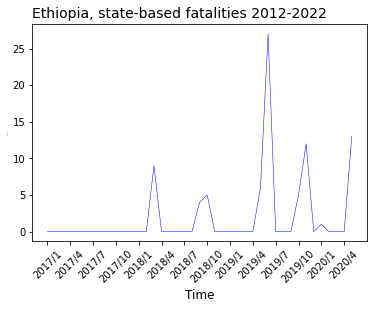

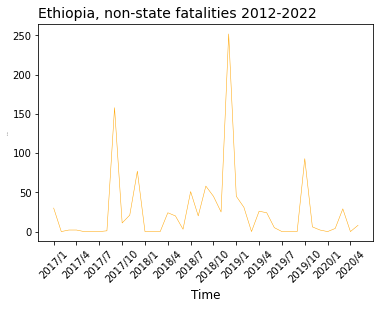

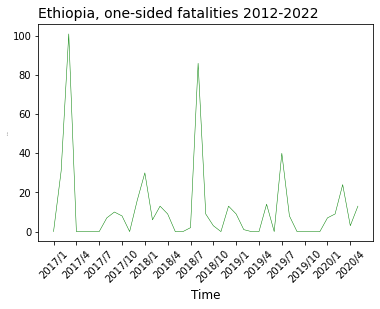

In [92]:
#graph the past 10 years, Ethiopia

for i in reference:

    mplot.figure()
    lim_fat_data_past10_ethiopia['ged_best_'+str(i[0])].plot(linewidth = 0.5, color=str(i[1]), 
                                                             label= str(i[2])+' violence')
    mplot.xticks(time_line_values, time_line_names, rotation=45)
    mplot.title('Ethiopia, ' + str(i[2])+ ' fatalities 2012-2022', loc='left', 
            fontsize=14, fontweight=0, color='black', y =1.0)
    mplot.xlabel("Time", fontsize=12)
    mplot.ylabel("Fatalities", fontsize=1)

    mplot.savefig(my_path+'/Ethiopia_past10_'+ str(i[0]), bbox_inches='tight', dpi=1200)
    

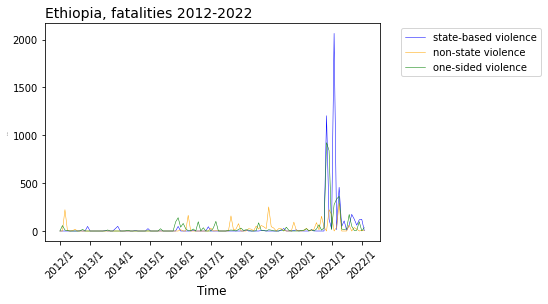

In [59]:
#graph the past 10 years, Ethiopia, all 3

for i in reference:
    lim_fat_data_past10_ethiopia['ged_best_'+str(i[0])].plot(linewidth = 0.5, color=str(i[1]), 
                                                             label= str(i[2])+' violence')
    mplot.xticks(time_line_values, time_line_names, rotation=45)
    mplot.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    mplot.title('Ethiopia, ' + 'fatalities 2012-2022', loc='left', 
            fontsize=14, fontweight=0, color='black', y =1.0)
    mplot.xlabel("Time", fontsize=12)
    mplot.ylabel("Fatalities", fontsize=1)

    

mplot.savefig(my_path+'/Ethiopia_past10_all', bbox_inches='tight', dpi=1200)



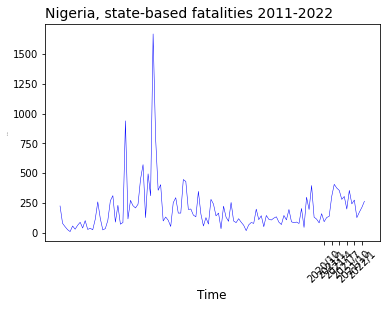

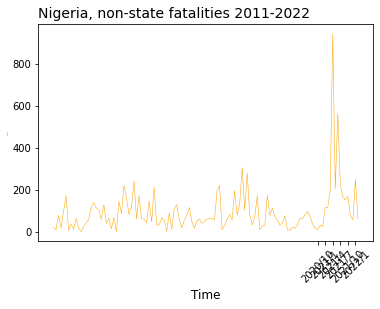

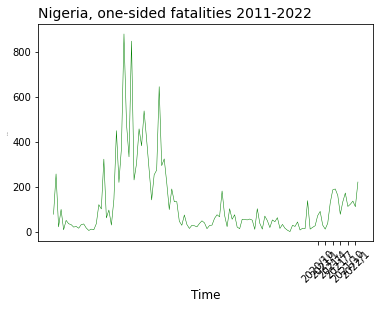

In [65]:
#graph the past 10 years, Nigeria

for i in reference:

    mplot.figure()
    lim_fat_data_past10_nigeria['ged_best_'+str(i[0])].plot(linewidth = 0.5, color=str(i[1]), 
                                                             label= str(i[2])+' violence')
    mplot.xticks(time_line_values, time_line_names, rotation=45)
    mplot.title('Nigeria, ' + str(i[2])+ ' fatalities 2011-2022', loc='left', 
            fontsize=14, fontweight=0, color='black', y =1.0)
    mplot.xlabel("Time", fontsize=12)
    mplot.ylabel("Fatalities", fontsize=1)

    mplot.savefig(my_path+'/Nigeria_past10_'+ str(i[0]), bbox_inches='tight', dpi=1200)
    
    
    

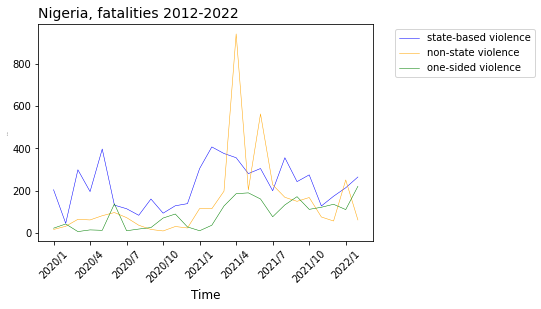

In [78]:
#graph the past 10 years, Nigeria, all 3

for i in reference:
    lim_fat_data_past10_nigeria['ged_best_'+str(i[0])].plot(linewidth = 0.5, color=str(i[1]), 
                                                             label= str(i[2])+' violence')
    mplot.xticks(time_line_values, time_line_names, rotation=45)
    mplot.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    mplot.title('Nigeria, ' + 'fatalities 2012-2022', loc='left', 
            fontsize=14, fontweight=0, color='black', y =1.0)
    mplot.xlabel("Time", fontsize=12)
    mplot.ylabel("Fatalities", fontsize=1)
    

mplot.savefig(my_path+'/Nigeria_past10_all', bbox_inches='tight', dpi=1200)